# Data Processing Version 5 - Updated Feb 24, 2023
1. Read Files
2. Segment Selection - select target TMC segments for input and output
3. Processing for Input Features and Output Ground Truth
    - Raw Speed & Imputation
    - Speed Feature Processing (TTI & SD)
    - Incident Processing
        - Mark as Incident based on (1) Waze & RCRS report and (2) slow down speed
        - Mark as Incident based on Abnormal Speed
        - For output ground truth, mark as incident based on upstream abnormal speed.
    - Density Processing
    - Miscellaneous (weather, time)
    - Concat Input Features Together and Normalize

### Key Differences from Data Preprocessing Version 1, 2, 3 & 4
- Based on the updated geoprocessing in (1) TMC-XD matching and (2) upstream segments, the target segements selected here are different.
- We are only targeting TMC segments. XD segments will be used only to impute missing TMC speed data.
- Dedicated TTI & SD processing rather than loading from Old X
- Updated input features and output ground truth arrangement

In [1]:
import csv
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import pickle

from datetime import datetime as dt
from collections import Counter
from scipy.spatial.distance import cdist
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from matplotlib import pyplot as plt

from utils import *

In [2]:
pwd

'/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/pipeline_v2/data_processing'

In [3]:
cd ..

/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/pipeline_v2


In [4]:
# Hyper-parameters during Data Processing 

# Dates and Timewindows that we are interested in 
start_date = dt(2019, 2, 10)
end_date = dt(2019, 7, 23)
start_min = 330 # 05:30:00 
end_min = 1260 # 21:00:00
busi_date = pd.bdate_range(start=start_date, end=end_date).date  # 117, note that the end_date here is inclusive 
all_date = pd.date_range(start=start_date, end=end_date).date # 164 dates, note that the end_date here is inclusive 
busi_idx = [i for i, b in enumerate(all_date) if b in busi_date]

# For Segment Selection
para_na_rate_spd_quantile_threshold_tmc_all = 1
para_na_rate_spd_quantile_threshold_xd = 1

# For incident processing
para_in_inc_spd_quantile_threshold = 0.15
para_out_inc_spd_quantile_threshold = 0.15
para_out_inc_space_limit = 5 # how far we are tracing upstream (5 miles here)
para_out_inc_tti_threshold = 1.6 # how slow the speed is compared with its reference speed (1.6 here)
para_out_inc_lead_time = 30 # how long we are marking in advance (30 min here)

## Part 1. Read Files

### 1.1 Old X

In [5]:
'''
Dates of old X & old Y: 2019.2.10 ~ 2019.7.23 (164 days, including all holidays & weekends)
Time Slots: 
    - For each day, there are 180 targeted time slots from 06:00:00 to 20:55:00
    - For each targeted time slot t (t in 06:00:00 ~ 20:55:00), 
        - old_Y contains padding of 7 slots (t-6, t-5, t-4, t-3, t-2, t-1, t)
        - old_X contains padding of 7 slots as input (t-12, t-11, t-10, t-9, t-8, t-7, t-6)
    
    In new_X and new Y, to allow for more flexibility of hyperparameters and reduce the file size, there won't be padding
    For example, for targeted time slot 06:00:00
        - old_Y has 05:30:00, 05:35:00, 05:40:00, 05:45:00, 05:50:00, 05:55:00, 06:00:00
        - old_X has 05:00:00, 05:05:00, 05:10:00, 05:15:00, 05:20:00, 05:25:00, 05:30:00
        - new_Y has 06:00:00
        - new_X has 05:30:00
'''
old_X = np.load("../data/old/old_X.npy")  # (29520, 7, 1008)
# old_Y = np.load("../data/old/old_Y.npy")  # (29520, 7, 162)
old_col = list(np.load("../data/old/old_col.npy", allow_pickle=True))  # 1008 (369 tti, 315 inc, 303 sd, 21 weather & time)

### 1.2 TMC Data

In [6]:
'''
Index: 1-min time slots from 05:30:00 to 20:59:00 on 117 business days during 2019-2-11 to 2019-07-23
Columns: 1000 TMC segments that are covered in both shape and 1-min speed data
'''
# Speed of All Vehicles in 1000 Segments 
df_spd_tmc_1min_all_1000 = pickle.load(open("../data/speed/cranberry_tmc_1min/df_downsampled_spd_tmc_1min_all_1000.pkl", "rb"))
df_spd_tmc_1min_all_1000.index = pd.to_datetime(df_spd_tmc_1min_all_1000.index)  # shape (108810, 1000), 2182919 NaN

# Density of All Vehicles in 1000 Segments 
df_dens_tmc_1min_all_1000 = pickle.load(open("../data/speed/cranberry_tmc_1min/df_downsampled_dens_tmc_1min_all_1000.pkl", "rb"))
df_dens_tmc_1min_all_1000.index = pd.to_datetime(df_dens_tmc_1min_all_1000.index)
# Ordinal Embedding
df_dens_tmc_1min_all_1000 = df_dens_tmc_1min_all_1000.replace(["A", "B", "C"], [1/6, 3/6, 5/6]) # shape (108810, 1000), 2182919 NaN


In [7]:
'''
Index: 5-min time slots from 05:30:00 to 20:55:00 on 117 business days during 2019-2-11 to 2019-07-23
Columns: 435 TMC segments that are covered in both shape and 5-min speed data
'''
# Speed in 435/424 Segments 
df_spd_tmc_5min_all_435 = pickle.load(open("../data/speed/cranberry_tmc_5min/df_downsampled_spd_tmc_5min_all_435.pkl", "rb"))
df_spd_tmc_5min_pv_435 = pickle.load(open("../data/speed/cranberry_tmc_5min/df_downsampled_spd_tmc_5min_pv_435.pkl", "rb"))
df_spd_tmc_5min_truck_424 = pickle.load(open("../data/speed/cranberry_tmc_5min/df_downsampled_spd_tmc_5min_truck_424.pkl", "rb"))
df_spd_tmc_5min_all_435.index = pd.to_datetime(df_spd_tmc_5min_all_435.index)  # shape (21762, 435), 4396123 NaN
df_spd_tmc_5min_pv_435.index = pd.to_datetime(df_spd_tmc_5min_pv_435.index)  # shape (21762, 435), 4699173 NaN
df_spd_tmc_5min_truck_424.index = pd.to_datetime(df_spd_tmc_5min_truck_424.index)  # (21762, 424), 7040151 NaN


# Density in 435/424 Segments 
df_dens_tmc_5min_all_435 = pickle.load(open("../data/speed/cranberry_tmc_5min/df_downsampled_dens_tmc_5min_all_435.pkl", "rb"))
df_dens_tmc_5min_pv_435 = pickle.load(open("../data/speed/cranberry_tmc_5min/df_downsampled_dens_tmc_5min_pv_435.pkl", "rb"))
df_dens_tmc_5min_truck_424 = pickle.load(open("../data/speed/cranberry_tmc_5min/df_downsampled_dens_tmc_5min_truck_424.pkl", "rb"))
df_dens_tmc_5min_all_435.index = pd.to_datetime(df_dens_tmc_5min_all_435.index)
df_dens_tmc_5min_pv_435.index = pd.to_datetime(df_dens_tmc_5min_pv_435.index)
df_dens_tmc_5min_truck_424.index = pd.to_datetime(df_dens_tmc_5min_truck_424.index)

# Ordinal Embedding
df_dens_tmc_5min_all_435 = df_dens_tmc_5min_all_435.replace(["A", "B", "C"], [1/6, 3/6, 5/6])  # shape (21762, 435), 4396123 NaN
df_dens_tmc_5min_pv_435 = df_dens_tmc_5min_pv_435.replace(["A", "B", "C"], [1/6, 3/6, 5/6])  # shape (21762, 435), 4699173 NaN
df_dens_tmc_5min_truck_424 = df_dens_tmc_5min_truck_424.replace(["A", "B", "C"], [1/6, 3/6, 5/6])  # (21762, 424), 7040151 NaN


In [8]:
# check for NaN rate of 1-min speed data of 1000 TMC segments
na_rate_spd_tmc_1min_all = df_spd_tmc_1min_all_1000.isna().mean()
print(na_rate_spd_tmc_1min_all.describe(), na_rate_spd_tmc_1min_all.quantile(q=para_na_rate_spd_quantile_threshold_tmc_all))

# check for NaN rate of 5-min speed data of 435 TMC segments
na_rate_spd_tmc_5min_all = df_spd_tmc_5min_all_435.isna().mean()
print(na_rate_spd_tmc_5min_all.describe(), na_rate_spd_tmc_5min_all.quantile(q=para_na_rate_spd_quantile_threshold_tmc_all))

count    1000.000000
mean        0.020062
std         0.058375
min         0.013859
25%         0.014171
50%         0.014171
75%         0.014171
max         0.985930
dtype: float64 0.9859296020586343
count    435.000000
mean       0.464389
std        0.354317
min        0.003630
25%        0.107251
50%        0.421055
75%        0.803993
max        0.999724
dtype: float64 0.9997242900468707


**\[Observation\]**

As can be seen from the result of NaN checking, 1-min speed data of 1000 TMC segments has fairly low NaN rate (~0.014) among nearly all 1000 segments. 

Therefore, although 5-min speed data of 435 segments have generally higher NaN rate, we can use 1-min speed data to impute. 

In this way, we don't get rid of any TMC segments due to high NaN rate.

### 1.3 XD Data

In [9]:
'''
Index: 1-min time slots from 05:30:00 to 20:59:00 on 117 business days during 2019-2-11 to 2019-07-23
Columns: 1104 XD segments that are covered in both shape and speed data
'''
# Speed of All Vehicles in All 1104 Segments 
df_spd_xd_1min_1104 = pickle.load(open("../data/speed/cranberry_xd_1min/df_downsampled_spd_xd_1min_1104.pkl", "rb"))
df_spd_xd_1min_1104.index = pd.to_datetime(df_spd_xd_1min_1104.index)  # shape (108810, 1104), 3085286 NaN

# Density of All Vehicles in All 1000 Segments 
df_dens_xd_1min_1104 = pickle.load(open("../data/speed/cranberry_xd_1min/df_downsampled_dens_xd_1min_1104.pkl", "rb"))
df_dens_xd_1min_1104.index = pd.to_datetime(df_dens_xd_1min_1104.index)  # shape (108810, 1104), 3085286 NaN
# Ordinal Embedding
df_dens_xd_1min_1104 = df_dens_xd_1min_1104.replace([10., 20., 30.], [1/6, 3/6, 5/6])

In [10]:
# check for NaN rate of 1-min speed data of 1104 XD segments
na_rate_spd_xd_1min = df_spd_xd_1min_1104.isna().mean()
print(na_rate_spd_xd_1min.describe(), na_rate_spd_xd_1min.quantile(q=para_na_rate_spd_quantile_threshold_xd))

count    1104.000000
mean        0.025684
std         0.049974
min         0.000000
25%         0.013289
50%         0.025117
75%         0.025117
max         0.451402
dtype: float64 0.45140152559507396


### 1.4 Geographical Correspondence between TMC & XD 

In [13]:
# with open("../data/xd_to_tmc_v2.pkl", "rb") as f:
#     xd_to_tmc = pickle.load(f) # <key>: tmc id (str); <value>: xd id (int)
dict_tmc_xd_join = pickle.load(open("../data/xd_to_tmc_v2.pkl", "rb")) # 269 tmc matched with 464 xd, <key>: tmc id (str); <value>: xd id (int)
# df_tmc_xd_join.columns = ['id_tmc', 'id_xd_int', 'prev_xd', 'next_xd', 'xd_start_lat',
#        'xd_start_long', 'xd_end_lat', 'xd_end_long', 'tmc_start_lat',
#        'tmc_start_long', 'tmc_end_lat', 'tmc_end_long', 'angle', 'Note']
# df_tmc_xd_join["id_xd_str"] = df_tmc_xd_join.id_xd_int.astype(str)

### 1.5 Upstream Segments within 5 Miles (used for slowdown speed calculation and incident feature processing)

In [14]:
# stored as dict() objects
# key: <id_tmc>
# value: list of upstream segments
limit = 5

dict_upstream_unique_tmc = pickle.load(open("../data/dict_upstream_unique_tmc_v2.pkl", "rb"))  # key: 273 TMC segments covered in shape, speed and incident data, (1 of which doesn't have any upstream segment)
dict_upstream_unique_tmc_5mile = pickle.load(open("../data/dict_upstream_unique_tmc_5_miles_v2.pkl", "rb"))  # key: 273 TMC segments covered in shape, speed and incident data, (1 of which doesn't have any upstream segment)

dict_prev_tmc = pickle.load(open("../data/dict_prev_tmc_v2.pkl", "rb"))   # key: 272 TMC segments covered in shape, speed and incident data, that have upstream segement(s)

### 1.6 Shapefile (used for visualization)

In [15]:
gdf_tmc = gpd.read_file("../data/shape/tmc_shape_cranberry/tmc_cranberry_v2.geojson")  # id and geometry of 315 unique tmc segments in cranberry shape file, 195 of which are covered in "spd_tmc"; shape (331, 2) 
gdf_tmc = gdf_tmc.rename(columns={"tmc":"id_tmc", "miles":"miles_tmc"})

gdf_xd = gpd.read_file("../data/shape/xd_shape_cranberry/xd_cranberry_for_sjoin_v2.geojson")  # features of 556 unique xd segments manually selected from PA shape file through QGIS; shape (556, 25)
gdf_xd = gdf_xd.rename(columns={"XDSegID":"id_xd_str", "PreviousXD":"id_xd_prev", "NextXDSegI":"id_xd_next", "Miles":"miles_xd"})

### 1.7 Set of Segments

In [16]:
set_tmc_segments_within_spd_shp_inc = pickle.load(open("./data_processing/set_tmc_segments_within_spd_shp_inc.pkl", "rb"))  # 273 TMC segments covered in shape, speed and incident data

## Part 2. Segment Selection for Input & Output

- We select target TMC segments based on 
    - speed data 
    - geo data
    - incident data
- There are two steps involved:
    1. Imputation of 1/5-min Speed Data based on TMC/XD Speed Data (1/5-min)
    2. Selection of TMC segments:
        - Covered by all of three data sources: 5-min Speed (with appropriate NaN rate), Geo, Incident
        - Have upstream segments


### 2.1 Imputation on Raw Speed

In [17]:
# 1. Impute 1-min TMC speed data of all vehicles with 1-min XD speed data
count = 0
for tmc in tqdm(df_spd_tmc_1min_all_1000.columns):
    if tmc in dict_tmc_xd_join:
        # there are 42 TMC segments that don't have any corresponding XD in df_spd_xd_1min_1104.
        corresponding_xd = [xd for xd in dict_tmc_xd_join[tmc] if xd in df_spd_xd_1min_1104.columns] 
        if len(corresponding_xd) == 0:
            count += 1
            continue
        df_spd_tmc_1min_all_1000[tmc] = df_spd_tmc_1min_all_1000[tmc].fillna(df_spd_xd_1min_1104[corresponding_xd].mean(axis=1))

# df_spd_tmc_1min_all_1000 now has 1962117 NaN (reduced from 2182919 NaN)

100%|██████████| 1000/1000 [00:39<00:00, 25.39it/s]


In [18]:
# Aggregate 1-min TMC speed data of all vehicles to 5-min for imputation use
df_spd_tmc_5min_all_1000 = df_spd_tmc_1min_all_1000.resample("5 min").mean() 
df_spd_tmc_5min_all_1000 = df_spd_tmc_5min_all_1000[pd.Index(df_spd_tmc_5min_all_1000.index.date).isin(busi_date)]
df_spd_tmc_5min_all_1000 = df_spd_tmc_5min_all_1000[(df_spd_tmc_5min_all_1000.index.hour * 60 + df_spd_tmc_5min_all_1000.index.minute >= start_min ) & (df_spd_tmc_5min_all_1000.index.hour * 60 + df_spd_tmc_5min_all_1000.index.minute < end_min)]  # 5-min frequency, (117 * 186, 1000), 177267 NaN

In [19]:
# 2. Impute 5-min TMC speed data of all vehicles with aggregated 5-min TMC speed data of all vehicles
count = 0
for tmc in tqdm(df_spd_tmc_5min_all_435.columns):
    # all TMC segments in df_spd_tmc_5min_all_435 are covered in df_spd_tmc_5min_all_1000
    if tmc not in df_spd_tmc_5min_all_1000.columns:
        count += 1
    else:
        df_spd_tmc_5min_all_435[tmc] = df_spd_tmc_5min_all_435[tmc].fillna(df_spd_tmc_5min_all_1000[tmc])

# df_spd_tmc_5min_all_435 now has 62725 NaN (reduced from 4396123 NaN)

100%|██████████| 435/435 [00:02<00:00, 214.07it/s]


In [20]:
# check for NaN rate of imputed 5-min speed data of 435 TMC segments
na_rate_spd_tmc_5min_all = df_spd_tmc_5min_all_435.isna().mean()
print(na_rate_spd_tmc_5min_all.describe(), na_rate_spd_tmc_5min_all.quantile(q=para_na_rate_spd_quantile_threshold_tmc_all))

count    435.000000
mean       0.006626
std        0.068814
min        0.000000
25%        0.000000
50%        0.000597
75%        0.002321
max        0.977346
dtype: float64 0.9773458321845419


**\[Observation\]**

Now the imputed 5-min speed data of 435 TMC segments has fairly low NaN rate among nearly all 435 segments. 

Therefore, we don't get rid of any TMC segments.

In [21]:
# 3. Impute 5-min TMC speed data internally (all, pv, truck)
df_spd_ratio_tmc_5min_pv_vs_all = df_spd_tmc_5min_pv_435.divide(df_spd_tmc_5min_all_435)
df_spd_ratio_tmc_5min_pv_vs_all[df_spd_ratio_tmc_5min_pv_vs_all == np.inf] = np.nan
df_spd_tmc_5min_pv_435 = df_spd_tmc_5min_pv_435.fillna(df_spd_tmc_5min_all_435*df_spd_ratio_tmc_5min_pv_vs_all.mean(axis=0))  # 62725 NaN

df_spd_ratio_tmc_5min_truck_vs_all = df_spd_tmc_5min_truck_424.divide(df_spd_tmc_5min_all_435)
df_spd_ratio_tmc_5min_truck_vs_all[df_spd_ratio_tmc_5min_truck_vs_all == np.inf] = np.nan
df_spd_tmc_5min_truck_424 = df_spd_tmc_5min_truck_424.fillna(df_spd_tmc_5min_all_435*df_spd_ratio_tmc_5min_truck_vs_all.mean(axis=0))  # 31254 NaN

In [22]:
print(df_spd_tmc_5min_pv_435.isna().mean().describe())
print(df_spd_tmc_5min_truck_424.isna().mean().describe())

count    435.000000
mean       0.006626
std        0.068814
min        0.000000
25%        0.000000
50%        0.000597
75%        0.002321
max        0.977346
dtype: float64
count    424.000000
mean       0.003387
std        0.047427
min        0.000000
25%        0.000000
50%        0.000574
75%        0.002252
max        0.977346
dtype: float64


### 2.2 Selection of TMC Segments

In [23]:
set_target_tmc = set_tmc_segments_within_spd_shp_inc.intersection(set(df_spd_tmc_5min_all_435.columns)).intersection(set(df_spd_tmc_5min_pv_435.columns)).intersection(set(df_spd_tmc_5min_truck_424.columns)).intersection(dict_prev_tmc) # 207 target TMC segments

list_target_tmc = list(set_target_tmc)

**\[Observation\]**

Although there are 273 TMC segments covered in shape, 1-min speed and 5-min incident data, only 207 of them are covered in 5-min vehicle-specific speed data. 

We cannot impute vehicle-specific speed data (pv & truck) of the remaining 65 TMC segments.

<AxesSubplot: title={'center': 'Visualization of Eventually Selected Target TMC (blue, 207) Segments'}>

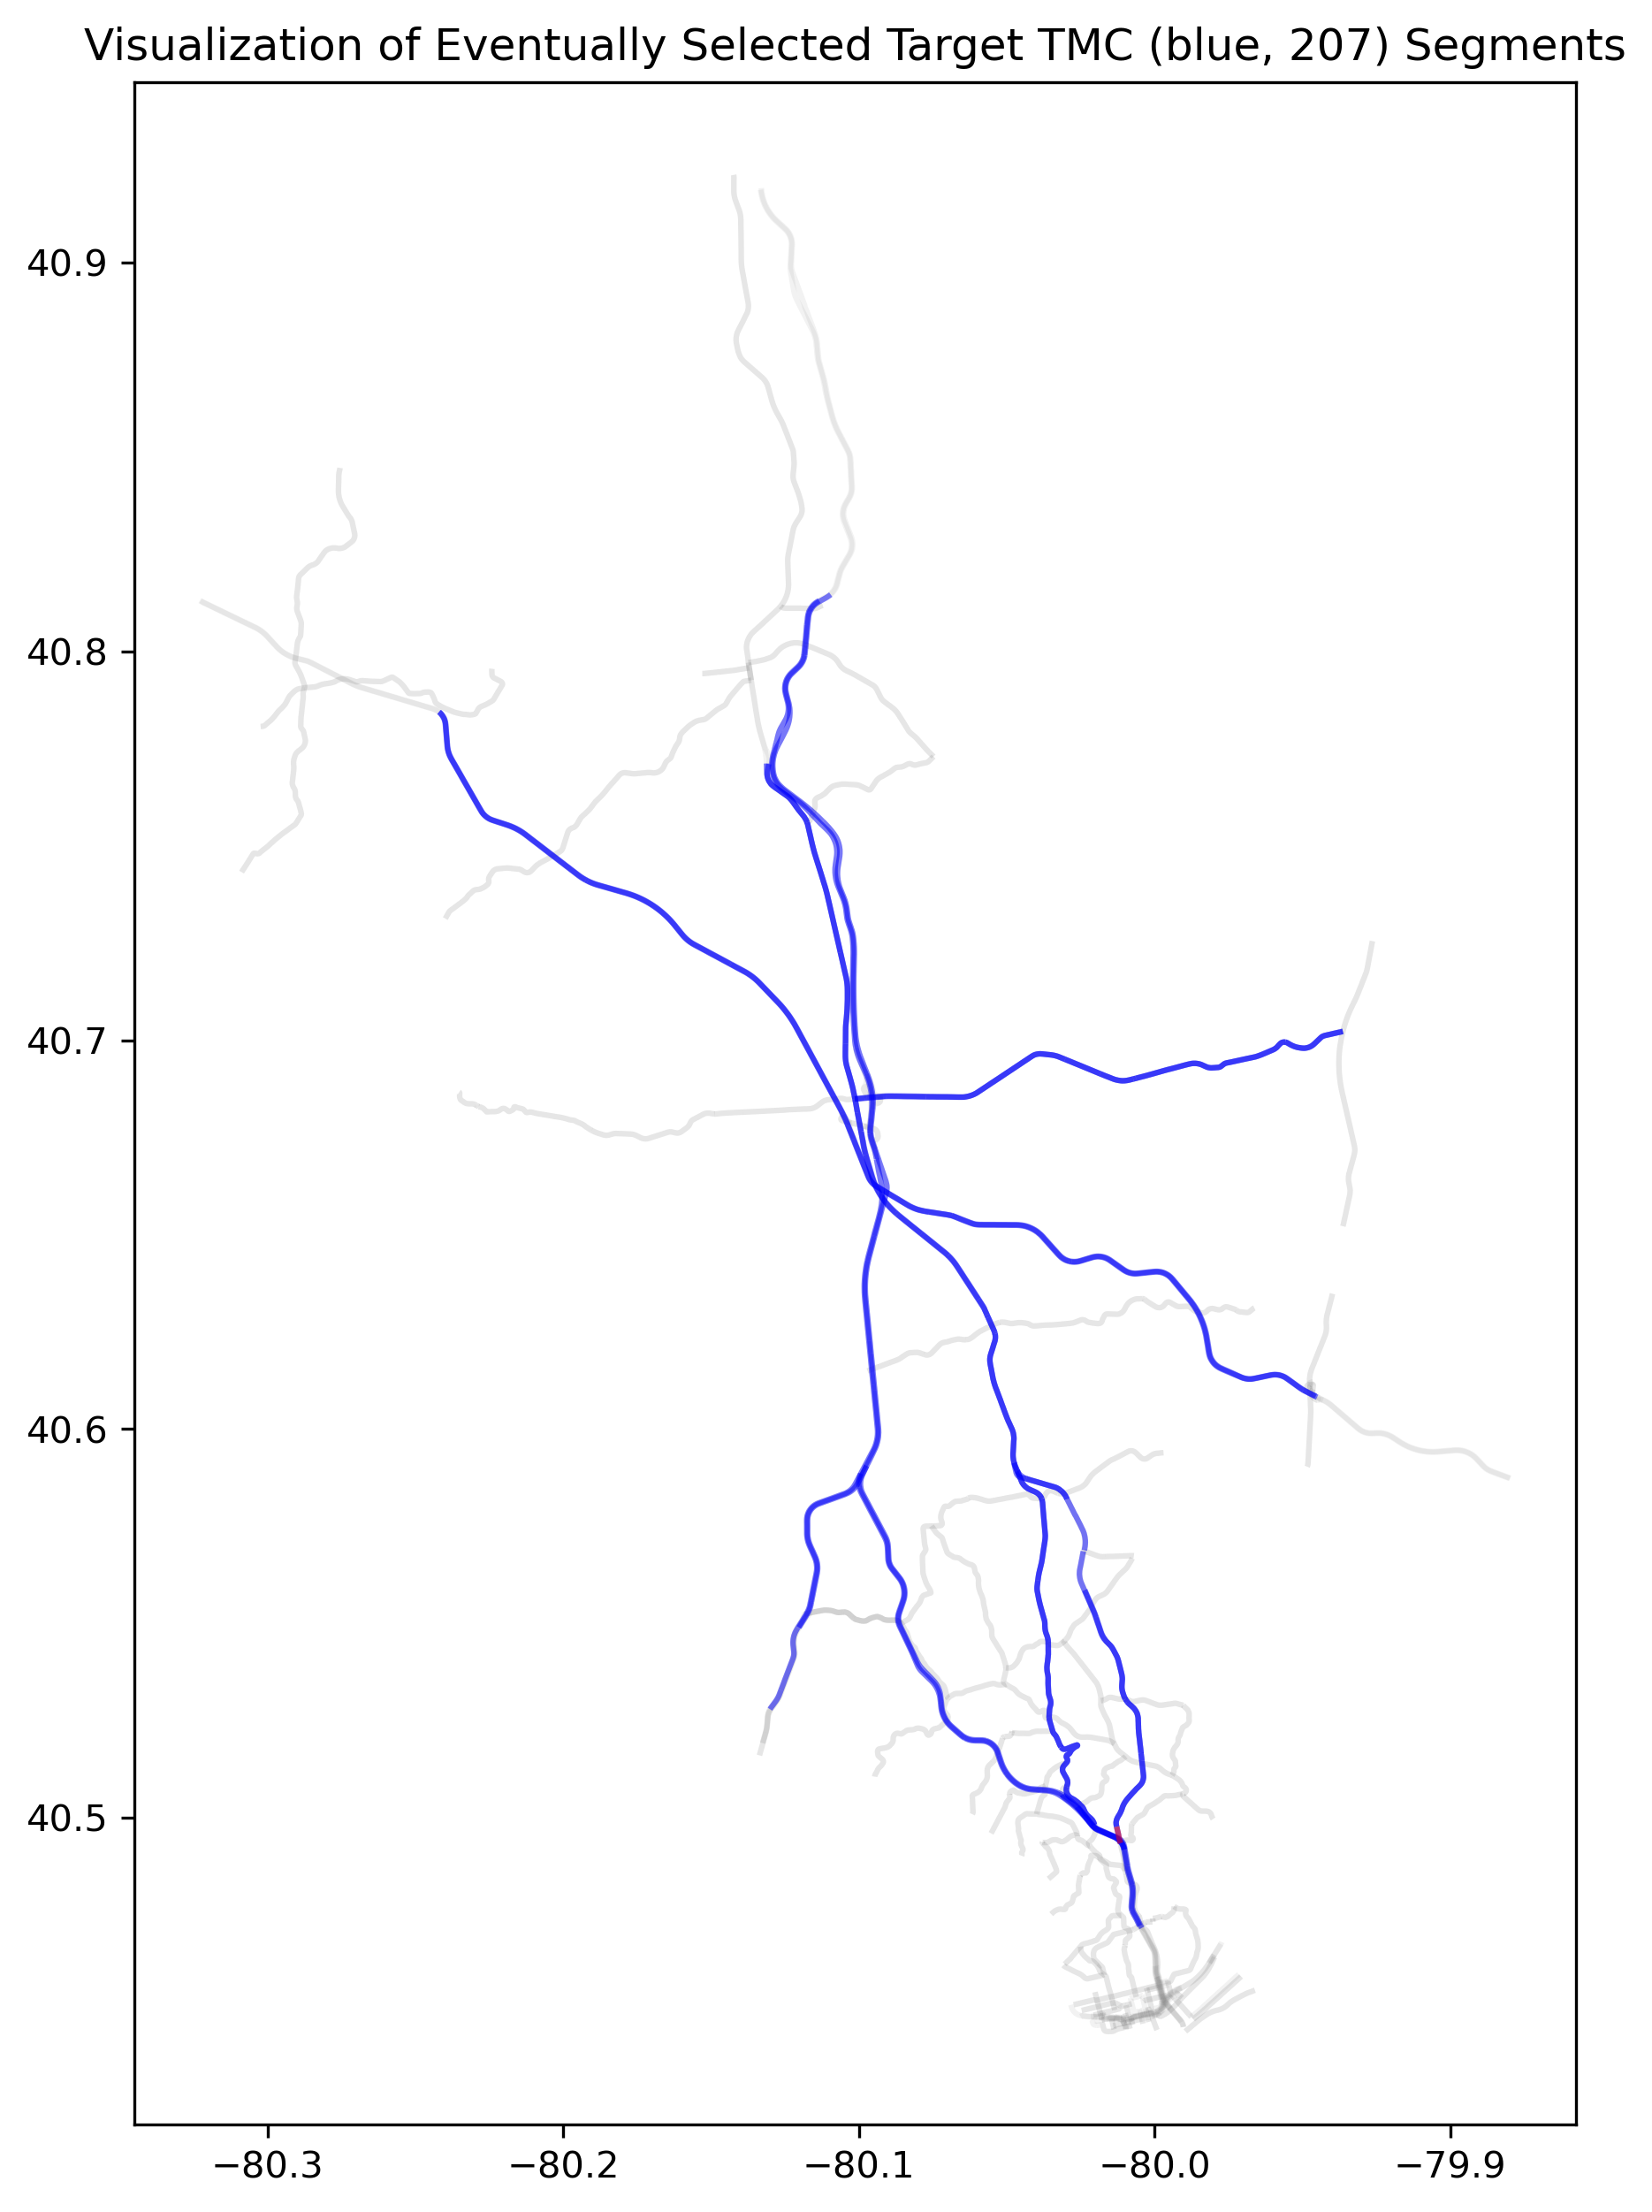

In [24]:
# fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
fig, ax = plt.subplots(1,figsize=(15,10), dpi=300)
ax.set_title("Visualization of Eventually Selected Target TMC (blue, 207) Segments")
gdf_tmc.plot(ax=ax, color="grey", alpha=0.1) # TMC segments in cranberry
gdf_tmc[gdf_tmc.id_tmc.isin(set_target_tmc)].plot(ax=ax, color="blue", alpha=0.5)  # 207 fianlized TMC target segments
gdf_tmc[gdf_tmc.id_tmc == "104P04638"].plot(ax=ax, color="red", alpha=0.5)  # The TMC segment that's excluded because it doesn't have upstream segments

## Part 3. Processing of Input Features and Output Ground Truth
1. Raw Speed (Imputation)
2. Speed Features
    - Time of Travel Index (TTI)
    - Slowdown Speed (SD)
4. Incident
5. Density
5. Miscellaneous
    - Weather & Time
    - Generation of Final Input Features & Output Ground Truth

### 3.1 Raw Speed

#### 3.1.1 Imputation

Note - Here I first include speed data from 05:30:00~20:55:00. In the sections afterwards, I will extract input feature (05:30:00~20:25:00) and output ground truth (06:00:00~20:55:00)

In [25]:
df_spd_tmc_5min_all_207 = df_spd_tmc_5min_all_435[list_target_tmc]  # shape (21762, 207), 1298 NaN
df_spd_tmc_5min_pv_207 = df_spd_tmc_5min_pv_435[list_target_tmc]  # shape (21762, 207), 1298 NaN
df_spd_tmc_5min_truck_207 = df_spd_tmc_5min_truck_424[list_target_tmc]  # shape (21762, 207), 1298 NaN

In [26]:
df_spd_tmc_5min_all_207 = df_spd_tmc_5min_all_207.fillna(method='ffill')  # 0 NaN
df_spd_tmc_5min_pv_207 = df_spd_tmc_5min_pv_207.fillna(method='ffill')  # 0 NaN
df_spd_tmc_5min_truck_207 = df_spd_tmc_5min_truck_207.fillna(method='ffill')  # 0 NaN

#### 3.1.2 Separate Input & Output and Save Speed Data into Files

In [27]:
df_in_spd_tmc_5min_all = df_spd_tmc_5min_all_207[(df_spd_tmc_5min_all_207.index.hour * 60 + df_spd_tmc_5min_all_207.index.minute >= start_min ) & (df_spd_tmc_5min_all_207.index.hour * 60 + df_spd_tmc_5min_all_207.index.minute < end_min-30)]  #(21060, 207)
df_in_spd_tmc_5min_pv = df_spd_tmc_5min_pv_207[(df_spd_tmc_5min_pv_207.index.hour * 60 + df_spd_tmc_5min_pv_207.index.minute >= start_min ) & (df_spd_tmc_5min_pv_207.index.hour * 60 + df_spd_tmc_5min_pv_207.index.minute < end_min-30)]  #(21060, 207)
df_in_spd_tmc_5min_truck = df_spd_tmc_5min_truck_207[(df_spd_tmc_5min_truck_207.index.hour * 60 + df_spd_tmc_5min_truck_207.index.minute >= start_min ) & (df_spd_tmc_5min_truck_207.index.hour * 60 + df_spd_tmc_5min_truck_207.index.minute < end_min-30)]  #(21060, 207)

In [28]:
df_out_spd_tmc_5min_all = df_spd_tmc_5min_all_207[(df_spd_tmc_5min_all_207.index.hour * 60 + df_spd_tmc_5min_all_207.index.minute >= start_min+30 ) & (df_spd_tmc_5min_all_207.index.hour * 60 + df_spd_tmc_5min_all_207.index.minute < end_min)]  #(21060, 207)
df_out_spd_tmc_5min_pv = df_spd_tmc_5min_pv_207[(df_spd_tmc_5min_pv_207.index.hour * 60 + df_spd_tmc_5min_pv_207.index.minute >= start_min+30 ) & (df_spd_tmc_5min_pv_207.index.hour * 60 + df_spd_tmc_5min_pv_207.index.minute < end_min)]  #(21060, 207)
df_out_spd_tmc_5min_truck = df_spd_tmc_5min_truck_207[(df_spd_tmc_5min_truck_207.index.hour * 60 + df_spd_tmc_5min_truck_207.index.minute >= start_min+30 ) & (df_spd_tmc_5min_truck_207.index.hour * 60 + df_spd_tmc_5min_truck_207.index.minute < end_min)]  #(21060, 207)

In [29]:
# Save speed data (both input and output)
pickle.dump(df_spd_tmc_5min_all_207, open("../data/df_spd_tmc_5min_all_207.pkl", "wb"))
pickle.dump(df_spd_tmc_5min_pv_207, open("../data/df_spd_tmc_5min_pv_207.pkl", "wb"))
pickle.dump(df_spd_tmc_5min_truck_207, open("../data/df_spd_tmc_5min_truck_207.pkl", "wb"))

### 3.2 Speed Features

#### 3.2.1 Time of Travel Index (TTI)

In [30]:
df_in_tti_tmc_5min = df_spd_tmc_5min_all_207.quantile(q=0.85, axis=0)/df_spd_tmc_5min_all_207
df_in_tti_tmc_5min = df_in_tti_tmc_5min[(df_in_tti_tmc_5min.index.hour * 60+ df_in_tti_tmc_5min.index.minute >= start_min ) & (df_in_tti_tmc_5min.index.hour * 60 + df_in_tti_tmc_5min.index.minute < end_min - 30)] 
df_in_tti_tmc_5min = df_in_tti_tmc_5min.where(df_in_tti_tmc_5min>1.0, 1.0) # (21060, 207)

#### 3.2.2 Slowdown Speed (SD)

In [31]:
# Aggregate 1-min XD speed data to 5-min for imputation use
df_spd_xd_5min_1104 = df_spd_xd_1min_1104.resample("5 min").mean() 
df_spd_xd_5min_1104 = df_spd_xd_5min_1104[pd.Index(df_spd_xd_5min_1104.index.date).isin(busi_date)]
df_spd_xd_5min_1104 = df_spd_xd_5min_1104[(df_spd_xd_5min_1104.index.hour * 60 + df_spd_xd_5min_1104.index.minute >= start_min ) & (df_spd_xd_5min_1104.index.hour * 60 + df_spd_xd_5min_1104.index.minute < end_min)]  # 5-min frequency, (117 * 186, 1000), 168325 NaN

In [32]:
# 1. TMC
df_avg_upstream_spd_tmc_5min = pd.DataFrame()  # avg upstream data for each target TMC segments

In [33]:
# Step 1. Collect speed data of all target tmc segments & their upstream segments, shape (21762, 1000)
df_spd_tmc_with_upstream_5min_all = df_spd_tmc_5min_all_1000.copy()  

for tmc in tqdm(list_target_tmc):
    # For target tmc segments, fill NaN with df_spd_tmc_5min_all_208
    df_spd_tmc_with_upstream_5min_all[tmc] = df_spd_tmc_with_upstream_5min_all[tmc].fillna(df_spd_tmc_5min_all_207[tmc])

    # Impute with XD speed data
    upstream = list(dict_upstream_unique_tmc[tmc].difference(df_spd_tmc_with_upstream_5min_all.columns))
    for u in upstream:
        # Speed data of some upstream TMC segments are not covered in df_spd_tmc_with_upstream_5min_all. We need to infer from corresponding XD data
        corresponding_xd = [xd for xd in dict_tmc_xd_join[u] if xd in df_spd_xd_5min_1104.columns] 
        if len(corresponding_xd) == 0:
            continue
        if u in df_spd_tmc_with_upstream_5min_all.columns:
            df_spd_tmc_with_upstream_5min_all[u] = df_spd_tmc_with_upstream_5min_all[u].fillna(df_spd_xd_5min_1104[corresponding_xd].mean(axis=1))
        else:
            df_spd_tmc_with_upstream_5min_all[u] = df_spd_xd_5min_1104[corresponding_xd].mean(axis=1)

100%|██████████| 207/207 [00:04<00:00, 42.80it/s]


In [34]:
# Step 2. Compute avg upstream data for all target TMC segments

count = 0
for tmc in tqdm(list_target_tmc):
    # All tmc have their avg upstream speed computed. 
    upstream_tmc = list(dict_upstream_unique_tmc[tmc].intersection(df_spd_tmc_with_upstream_5min_all.columns))
    if len(upstream_tmc) == 0:
        count += 1
    df_avg_upstream_spd_tmc_5min[tmc] = df_spd_tmc_with_upstream_5min_all[upstream_tmc].mean(axis=1)

# df_avg_upstream_spd_tmc_5min: shape (21762, 207), 394 NaN

 47%|████▋     | 98/207 [00:00<00:00, 322.66it/s]/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_5312/1040241567.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_upstream_spd_tmc_5min[tmc] = df_spd_tmc_with_upstream_5min_all[upstream_tmc].mean(axis=1)
/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_5312/1040241567.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_avg_upstream_spd_tmc_5min[tmc] = df_spd_tmc_with_upstream_5min_all[upstream_tmc].mean(axis=1)
/var/folders/y2/1kk0np3x01qchz21plxx_

In [35]:
# Step 3. Fill NaN in avg upstream data for all target TMC segments
# shape (21762, 207), 394 NaN
df_avg_upstream_spd_tmc_5min = df_avg_upstream_spd_tmc_5min.fillna(method="ffill") # 0 NaN

In [36]:
# Step 4. Compute Slowdown Speed of all target TMC segments
df_in_sd_tmc_5min = df_avg_upstream_spd_tmc_5min-df_spd_tmc_5min_all_207
df_in_sd_tmc_5min = df_in_sd_tmc_5min.where(df_in_sd_tmc_5min>0, 0.0)
df_in_sd_tmc_5min = df_in_sd_tmc_5min[(df_in_sd_tmc_5min.index.hour * 60+ df_in_sd_tmc_5min.index.minute >= start_min ) & (df_in_sd_tmc_5min.index.hour * 60 + df_in_sd_tmc_5min.index.minute < end_min-30)]  # shape (21060, 207)

#### 3.2.3 Save Files

In [37]:
# Save speed features 
pickle.dump(df_in_tti_tmc_5min, open("../data/df_in_tti_tmc_5min.pkl", "wb"))
pickle.dump(df_in_sd_tmc_5min, open("../data/df_in_sd_tmc_5min.pkl", "wb"))

### 3.3 Incident Processing

#### 3.3.1 Incident Input Features

##### 3.3.1.1 Load Incident Features from Old X Input (173 tmc segments)

In [38]:
# get indices of old_col that will remain as new columns
col_idx = []  # will store the indices of 228 old columns that will become new_X (207 inc, 21 weather & time)
col_name = []
for i in range(987):
    c = old_col[i]
    if "inc" in c and c[4:] in set_target_tmc:
        col_idx.append(i)
        col_name.append(c[4:])
col_idx += list(range(987, 1008)) # len 228, incident features: 1~207, weather & time: 208~228

In [39]:
np_in_inc_5min = old_X[:, -1, col_idx[:207]].reshape(164, 180, -1) # (164, 180, 194) 164 days (busi + non-busi) * 180 daily time slots (05:30:00 ~ 20:25:00)
np_in_wt_5min = old_X[:, -1, col_idx[207:]].reshape(164, 180, -1) # (164, 180, 194) 164 days (busi + non-busi) * 180 daily time slots (05:30:00 ~ 20:25:00)

# select business dates only
np_in_inc_5min = np_in_inc_5min[busi_idx, :, :].reshape(-1, 207)  # (117*180, 207)
np_in_wt_5min = np_in_wt_5min[busi_idx, :, :].reshape(-1, 21)  # (117*180, 21)

In [40]:
# Convert to DataFrame, with datatime objects as indices
df_in_inc_5min = pd.DataFrame(np_in_inc_5min, columns=col_name)  # (21060, 207)
df_in_inc_5min.index = df_in_spd_tmc_5min_all.index

df_in_wt_5min = pd.DataFrame(np_in_wt_5min) # (21060, 21)
df_in_wt_5min.index = df_in_spd_tmc_5min_all.index

In [41]:
# Sort the order of columns to align with other DataFrame
df_in_inc_5min = df_in_inc_5min[df_in_spd_tmc_5min_all.columns]

##### 3.3.1.2 Mark Segments with Abnormal Speed as in Incident Status

In [42]:
# Set incident status = max(original value, 1) when the speed is slower than 15% percentile
df_in_abn_spd_tmc_all_5min = (df_in_spd_tmc_5min_all<df_in_spd_tmc_5min_all.quantile(q=para_in_inc_spd_quantile_threshold, axis=0)).astype(float)
df_in_inc_5min = df_in_inc_5min.where(df_in_inc_5min >= df_in_abn_spd_tmc_all_5min, df_in_abn_spd_tmc_all_5min)

#### 3.3.2 Output Incident Ground Truth

##### 3.3.2.1 Load Output Incident Data

In [43]:
df_out_inc_5min = pd.read_csv("../data/incident_labels.csv") 
df_out_inc_5min = df_out_inc_5min.set_index("measurement_tstamp")
df_out_inc_5min.index = pd.to_datetime(df_out_inc_5min.index)
df_out_inc_5min = df_out_inc_5min[df_out_spd_tmc_5min_all.columns]
df_out_inc_5min = df_out_inc_5min[(pd.Index(df_out_inc_5min.index.date).isin(busi_date)) & (df_out_inc_5min.index.hour*60 + df_out_inc_5min.index.minute >= start_min+30) & (df_out_inc_5min.index.hour*60 + df_out_inc_5min.index.minute < end_min) ]  # shape (21060, 207)

##### 3.3.2.2 Mark Segments with Abnormal Speed as in Incident Status

In [44]:
# Set incident status = max(original value, 1) when the speed is slower than 15% percentile
df_out_abn_spd_tmc_all_5min = (df_out_spd_tmc_5min_all<df_out_spd_tmc_5min_all.quantile(q=para_out_inc_spd_quantile_threshold, axis=0)).astype(float)
df_out_inc_5min = df_out_inc_5min.where(df_out_inc_5min >= df_out_abn_spd_tmc_all_5min, df_out_abn_spd_tmc_all_5min)

##### 3.3.2.3 Mark Appropriate Upstream Segments as in Incident
We define appropriate upstream segments with the following hyper-parameters:
- para_out_inc_space_limit: how far we are tracing upstream (5 miles here)
- para_out_inc_tti_threshold: how slow the speed is compared with its reference speed (1.6 here)
- para_out_inc_lead_time: how long we are marking in advance (30 min here)

In [45]:
df_out_tti_tmc = df_spd_tmc_5min_all_207.quantile(q=0.85, axis=0)/df_spd_tmc_5min_all_207
df_out_tti_tmc = df_out_tti_tmc[(df_out_tti_tmc.index.hour * 60+ df_out_tti_tmc.index.minute >= start_min+30 ) & (df_out_tti_tmc.index.hour * 60 + df_out_tti_tmc.index.minute < end_min)] 
df_out_tti_tmc = df_out_tti_tmc.where(df_out_tti_tmc>1.0, 1.0) # (21060, 207)

In [46]:
for tmc in tqdm(df_out_inc_5min.columns):
    upstream_target = list(dict_upstream_unique_tmc_5mile[tmc].intersection(set_target_tmc))

    # Compute time slots (incident time + lead time)
    inc_time = list((df_out_inc_5min[[tmc]]>0).index)
    time_slots = set()
    for time in inc_time:
        for t in range(int(para_out_inc_lead_time//5+1)): # lead time
            next_time = time + pd.Timedelta(minutes=5*t)
            if next_time not in time_slots and next_time.date() == time.date() and next_time.hour * 60 + next_time.minute <= 1255:
                time_slots.add(next_time)

    # Compute the dataframe of appropriate upstream segments in corresponding time slots
    df_appro_upstream = (df_out_tti_tmc[df_out_tti_tmc.index.isin(time_slots)][upstream_target] > para_out_inc_tti_threshold).astype(float) 

    # Mark when appropriate
    df_out_inc_5min.loc[time_slots, upstream_target] = df_out_inc_5min[df_out_inc_5min.index.isin(time_slots)][upstream_target].where(df_out_inc_5min[df_out_inc_5min.index.isin(time_slots)][upstream_target] >= df_appro_upstream, df_appro_upstream)



  0%|          | 0/207 [00:00<?, ?it/s]/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_5312/3339406174.py:17: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_inc_5min.loc[time_slots, upstream_target] = df_out_inc_5min[df_out_inc_5min.index.isin(time_slots)][upstream_target].where(df_out_inc_5min[df_out_inc_5min.index.isin(time_slots)][upstream_target] >= df_appro_upstream, df_appro_upstream)
  0%|          | 1/207 [00:00<01:52,  1.84it/s]/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_5312/3339406174.py:17: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_out_inc_5min.loc[time_slots, upstream_target] = df_out_inc_5min[df_out_inc_5min.index.isin(time_slots)][upstream_target].where(df_out_inc_5min[df_out_inc_5min.index.isin(time_slots)][upstream_target] >= df_appro_upstream, df_appro_upstream)
  1%|          | 2/207 [00:01<01

#### 3.3.3 Save Files

In [47]:
# Save speed features 
pickle.dump(df_in_inc_5min, open("../data/df_in_inc_5min.pkl", "wb"))
pickle.dump(df_out_inc_5min, open("../data/df_out_inc_5min.pkl", "wb"))

# Save weather & time features
pickle.dump(df_in_wt_5min, open("../data/df_in_wt_5min.pkl", "wb"))

### 3.4 Density Processing

In [1]:
# 1. Impute 1-min TMC density data of all vehicles with 1-min XD density data
count = 0
for tmc in tqdm(df_dens_tmc_1min_all_1000.columns):
    if tmc in dict_tmc_xd_join:
        # there are 42 TMC segments that don't have any corresponding XD in df_dens_xd_1min_1104.
        corresponding_xd = [xd for xd in dict_tmc_xd_join[tmc] if xd in df_dens_xd_1min_1104.columns] 
        if len(corresponding_xd) == 0:
            count += 1
            continue
        df_dens_tmc_1min_all_1000[tmc] = df_dens_tmc_1min_all_1000[tmc].fillna(df_dens_xd_1min_1104[corresponding_xd].mean(axis=1))

# df_dens_tmc_1min_all_1000 now has 1962117 NaN (reduced from 2182919 NaN)

NameError: name 'tqdm' is not defined

In [76]:
# Aggregate 1-min TMC density data of all vehicles to 5-min for imputation use
df_dens_tmc_5min_all_1000 = df_dens_tmc_1min_all_1000.resample("5 min").mean() 
df_dens_tmc_5min_all_1000 = df_dens_tmc_5min_all_1000[pd.Index(df_dens_tmc_5min_all_1000.index.date).isin(busi_date)]
df_dens_tmc_5min_all_1000 = df_dens_tmc_5min_all_1000[(df_dens_tmc_5min_all_1000.index.hour * 60 + df_dens_tmc_5min_all_1000.index.minute >= start_min ) & (df_dens_tmc_5min_all_1000.index.hour * 60 + df_dens_tmc_5min_all_1000.index.minute < end_min)]  # 5-min frequency, (117 * 186, 1000), 177267 NaN

In [86]:
# 2. Impute 5-min TMC speed data of all vehicles with aggregated 5-min TMC speed data of all vehicles
df_dens_tmc_5min_all_207 = df_dens_tmc_5min_all_435[set_target_tmc] # shape (21762, 207), 1257479 NaN

count = 0
for tmc in tqdm(df_dens_tmc_5min_all_207.columns):
    # all TMC segments in df_dens_tmc_5min_all_207 are covered in df_dens_tmc_5min_all_1000
    if tmc not in df_dens_tmc_5min_all_1000.columns:
        count += 1
    else:
        df_dens_tmc_5min_all_207[tmc] = df_dens_tmc_5min_all_207[tmc].fillna(df_dens_tmc_5min_all_1000[tmc])

# df_dens_tmc_5min_all_207 now has 1298 NaN (reduced from 1257479 NaN)

/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_39165/982348393.py:2: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_dens_tmc_5min_all_207 = df_dens_tmc_5min_all_435[set_target_tmc] # shape (21762, 207), 1257479 NaN
  0%|          | 0/207 [00:00<?, ?it/s]/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_39165/982348393.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dens_tmc_5min_all_207[tmc] = df_dens_tmc_5min_all_207[tmc].fillna(df_dens_tmc_5min_all_1000[tmc])
100%|██████████| 207/207 [00:00<00:00, 501.95it/s]


In [87]:
# 3. Impute with Lowest Value (1/6 <=> "A", which denotes "fewer than five values")
df_dens_tmc_5min_all_207 = df_dens_tmc_5min_all_207.fillna(1/6)    # 0 NaN

In [89]:
# Extract Input (05:30:00~20:25:00)
df_in_dens_tmc_5min = df_dens_tmc_5min_all_207[(df_dens_tmc_5min_all_207.index.hour * 60 + df_dens_tmc_5min_all_207.index.minute >= start_min ) & (df_dens_tmc_5min_all_207.index.hour * 60 + df_dens_tmc_5min_all_207.index.minute < end_min-30)] # shape (21060, 207), 0 NaN

In [91]:
# Save density features 
pickle.dump(df_in_dens_tmc_5min, open("../data/df_in_dens_tmc_5min.pkl", "wb"))

### 3.5 Generate Final Input and Output

#### 3.5.1 Merge Features into Input

In [123]:
# (21060, 1470) 
# second dimension: 
#     207 TMC Density 
#     1035 TMC Speed Features
#         621 TMC vehicle-specific speed (207*3: all, truck, pv) 
#         207 TMC tti
#         207 TMC sd 
#     207 TMC Incident
#     21 Weather & Time
list_df_in_5min = [df_in_dens_tmc_5min, df_in_spd_tmc_5min_all, df_in_spd_tmc_5min_truck, df_in_spd_tmc_5min_pv, df_in_tti_tmc_5min, df_in_sd_tmc_5min, df_in_inc_5min, df_in_wt_5min]
np_in_5min = np.concatenate([df.to_numpy() for df in list_df_in_5min], axis=1) 

In [124]:
# Scaling Normalization (min-max normalization)
scaler = MinMaxScaler()
np_in_5min = scaler.fit_transform(np_in_5min)

In [125]:
np.save("../data/np_in_5min.npy", np_in_5min)

#### 3.5.2 Merge Ground Truth Data into Output

In [135]:
list_df_out_5min = [df_out_spd_tmc_5min_all, df_out_spd_tmc_5min_truck, df_out_spd_tmc_5min_pv, df_out_inc_5min]
np_out_5min = np.concatenate(list_df_out_5min, axis=1)  # (21060, 207*4)
np_out_5min = np_out_5min.reshape((21060, 207, 4),order='F') # (21060, 207, 4)

In [137]:
np.save("../data/np_out_5min.npy", np_out_5min)

In [105]:
# save column names for visualization of model inference results
pickle.dump(list_target_tmc, open("../data/columns_tmc.pkl", "wb"))  # list_target_tmc matches the order of TMC segments in the columns of input & output dataframes

## Part 4. Waze DataFrame

Generate Waze report dataframe for target TMC segments. The dataframe will be used to measure timeliness of incident status prediction by our 2-stage model.

In [116]:
'''
size (47520, 315)
47520: 165 days (2019.2.10 ~ 2019.7.24) * 24 hrs * 12 slots/hr
'''
df_waze_5min = pd.read_pickle("../data/waze_df.pickle")
df_waze_5min = df_waze_5min[list_target_tmc]
df_waze_5min = df_waze_5min[
            (pd.Index(df_waze_5min.index.date).isin(busi_date)) & 
            (df_waze_5min.index.hour*60 + df_waze_5min.index.minute >= start_min+30) & 
            (df_waze_5min.index.hour*60 + df_waze_5min.index.minute < end_min)
            ]  # shape (21060, 207), 0 NaN

In [120]:
pickle.dump(df_waze_5min, open("../data/df_waze_5min_207.pkl", "wb"))

## Part 5. GNN Data

For GNN, we need three pieces of data:
- Input Features
    - Node Embedding
    - Adjacency Matrix
- Output Ground Truth <- we can use np_out_5min of shape (21060, 207, 4) as ground truth


In [175]:
# Node Embedding
# shape (21060, 207, 28)
np_node_embedding = np.moveaxis(np.stack([df.to_numpy() for df in list_df_in_5min[:-1]]), 0, -1)  # node embedding without weather/time, shape (21060, 207, 7)
np_wt_embedding = df_in_wt_5min.to_numpy().reshape(21060, 1, 21).repeat(207, axis=1) # node embedding of weather & time, shape (21060, 207, 21)
np_node_embedding = np.concatenate([np_node_embedding, np_wt_embedding], axis=2) # final node embedding, shape (21060, 207, 28)

In [183]:
# Adjacency Matrix

# initialization
np_adj_matrix = np.zeros(shape=(207, 207))  # np_adj_matrix[i, j] = 1 means segment i is connected with segment j with direction i->j, otherwise 0

# create dictionary storing the index of TMC segments in the list 
dict_index_target_tmc = dict()
for i, tmc in enumerate(list_target_tmc):
    dict_index_target_tmc[tmc] = i

# populate adjacency matrix
for tmc in list_target_tmc:
    for prev_tmc in dict_prev_tmc[tmc]:
        if prev_tmc in dict_index_target_tmc:
            np_adj_matrix[dict_index_target_tmc[prev_tmc], dict_index_target_tmc[tmc]] = 1

In [188]:
np_adj_matrix.sum(axis=0)  # sum by column, value denotes the number of **targeted** prev TMC segments each TMC segment

array([1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [193]:
list_tmc_no_target_prev = [list_target_tmc[i] for i,v in enumerate(np_adj_matrix.sum(axis=0)) if v == 0]
'''
'104+04643', '104+04639', '104-04636', '104-04642', '104P04635', '104P04439', '104P04527', '104-06681', '104N13684', '104N04784', '104+09196', '104P04539', '104N06230'
'''

<AxesSubplot: title={'center': "207 Target TMC Segments (blue), 13 (red) of which don't have previous neighbor covered in target list"}>

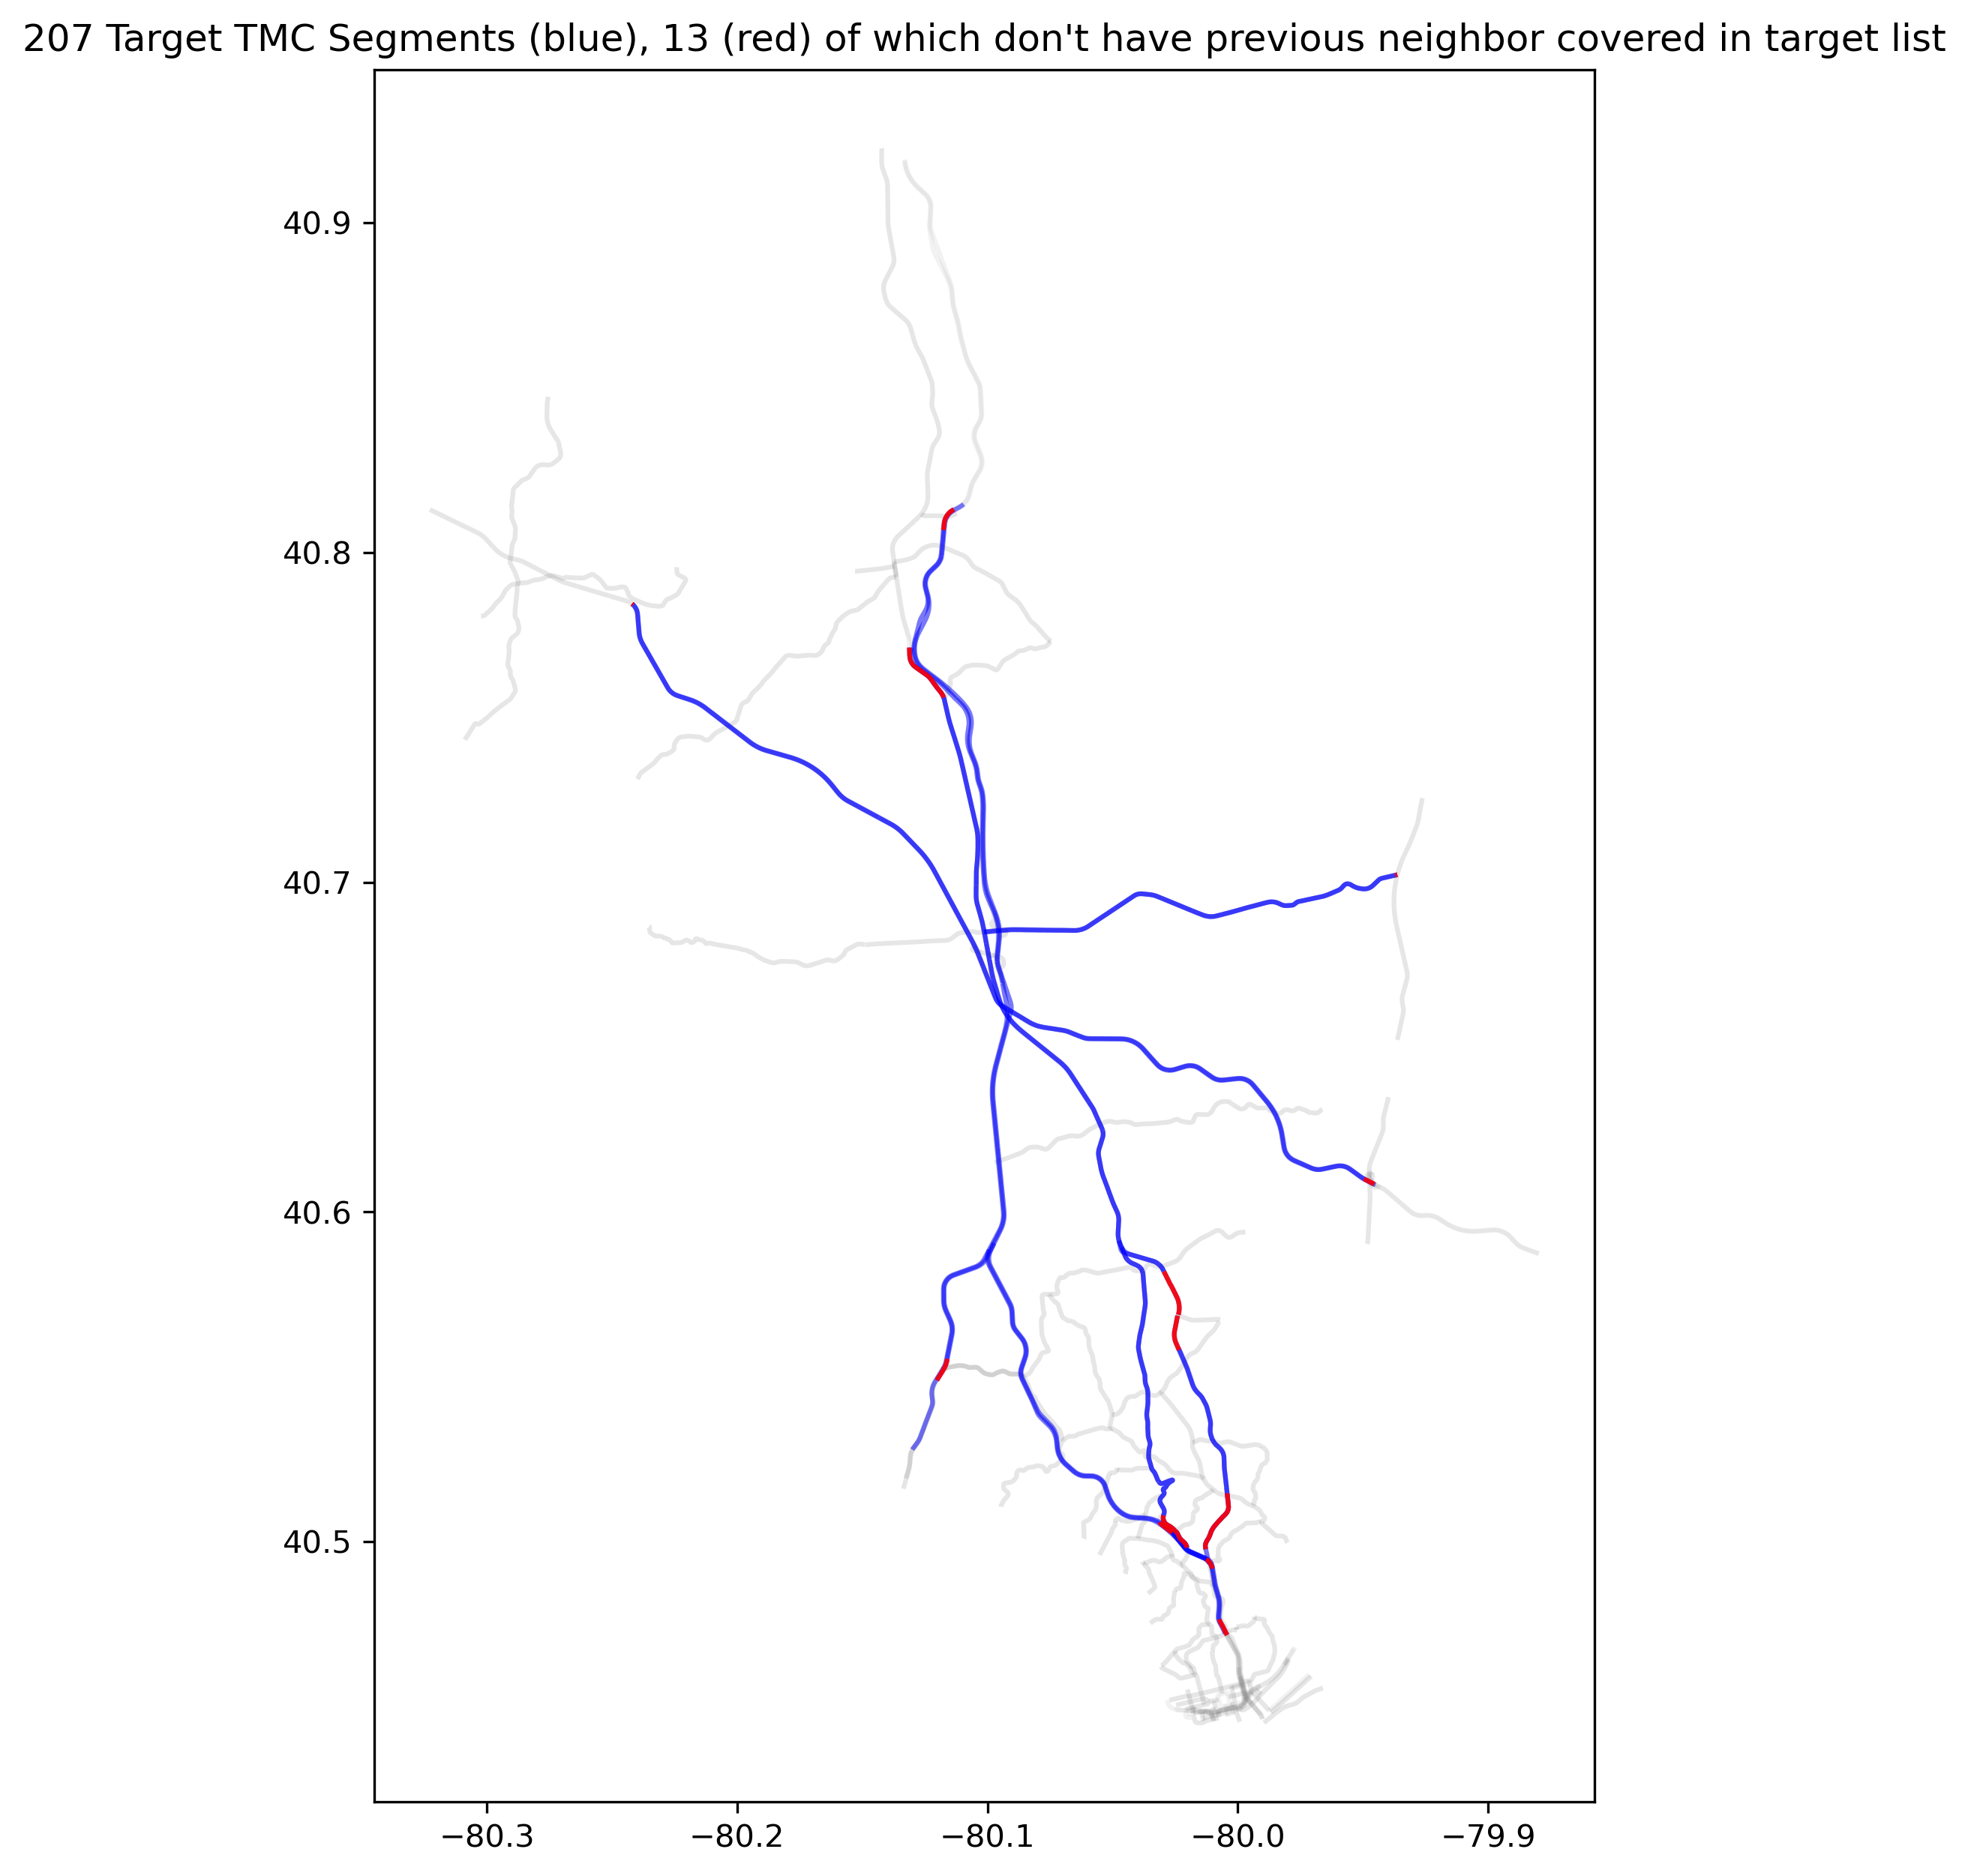

In [197]:
# fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
fig, ax = plt.subplots(1,figsize=(15,10), dpi=300)
ax.set_title("207 Target TMC Segments (blue), 13 (red) of which don't have previous neighbor covered in target list")
gdf_tmc.plot(ax=ax, color="grey", alpha=0.1) # TMC segments in cranberry
gdf_tmc[gdf_tmc.id_tmc.isin(set_target_tmc)].plot(ax=ax, color="blue", alpha=0.5)  # 207 target TMC segments
gdf_tmc[gdf_tmc.id_tmc.isin(list_tmc_no_target_prev)].plot(ax=ax, color="red", alpha=0.9)  # 13 target TMC segment without any prev segments covered in target list

**\[Observation\]**
- In dict_prev_tmc, all of targeted TMC segments have prev segment(s). This is because we include all prev segment(s), regardless of whether these prev segment(s) are covered in speed or incident data or not
- Here, when we compute adjacency matrix, we only care about geographical relationship among **targeted** TMC segments, i.e. we pay attention to prev segment(s) that are within the target list. Therefore, 13 TMC segments don't have any prev segments that lie within target list

In [198]:
np.save("../data/np_in_node_embedding_5min.npy", np_node_embedding)
np.save("../data/np_in_adj_mat_207.npy", np_adj_matrix)